In [2]:
'Bismillah'

'Bismillah'

In [3]:
import numpy as np
from imblearn.combine import SMOTETomek
from numpy import isnan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from datetime import date
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn_extra.cluster import KMedoids
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn.metrics import classification_report,confusion_matrix
import optuna
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from functools import partial
from sklearn.feature_selection import VarianceThreshold
from optuna import Trial, visualization
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,f_classif
import collections
from collections import Counter
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from numpy import std
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')

dataset = pd.read_csv("Train.csv")

In [4]:
class feat_sel(BaseEstimator, TransformerMixin):
    def __init__(self, dtype='numeric'):
        self.dtype = dtype

    def fit( self, X, y=None ):
        return self 

    def transform(self, X, y=None):
        if self.dtype == 'numeric':
            num_cols = X.columns[X.dtypes != object].tolist()
            return X[num_cols]
        elif self.dtype == 'category':
            cat_cols = X.columns[X.dtypes == object].tolist()
            return X[cat_cols]
    def get_feature_names(self):
        if self.dtype == 'numeric':
            num_cols = X.columns[X.dtypes != object].tolist()
            return X[num_cols]
        elif self.dtype == 'category':
            cat_cols = X.columns[X.dtypes == object].tolist()
            return X[cat_cols]

        
class Label_encode(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X,y=None):
        X['Segment']=X['Segment'].replace({'Champions':9,'Loyal customers':8,'Cant loose them':7,'At risk':6,
                                           'Potential loyalist':5,'Need attention':4,'Promising':3,'New customers':2,
                                           'About to sleep':1,'Lost':0}, regex=True)
        X['Marital_Status']=X['Marital_Status'].replace({'Divorced':0,'Single':0,
                                                                        'Married':1,'Together':1,                                                  
                                                         'Absurd':0,'Widow':0,'YOLO':0,'Alone':0}, regex=True)
        self.columns = X.columns
        return X
    def get_feature_names(self):
        return list(self.columns)

    
class df_unskewed(TransformerMixin,BaseEstimator):
    
    def __init__(self, method='yeo-johnson'):
        
        self.method = method
        self.standardize=False #Standardize = False as we use the custom class "df_scaler"

    def fit(self, X, y=None):
        if self.method == 'yeo-johnson':
            self.scl = PowerTransformer(method=self.method,standardize=False)
            self.scl.fit(X)
            return self
        elif self.method == 'None':
            return self

    def transform(self, X):
        if self.method == 'yeo-johnson':
            Xscl = self.scl.transform(X)
            Xscaled = pd.DataFrame(Xscl, index=X.index, columns=X.columns)
            self.columns = X.columns
            return Xscaled
        elif self.method == 'None':
            Xscl = X
            Xscaled = pd.DataFrame(Xscl, index=X.index, columns=X.columns)
            self.columns = X.columns
            return Xscaled
    def get_feature_names(self):
        return list(self.columns)



class df_scaler(BaseEstimator, TransformerMixin):
    def __init__(self, method=StandardScaler()):
        super().__init__()
        self.method = method        

    def fit(self, X, y=None):
        return self.method.fit(X)

    def transform(self, X, y=None):
        Xscl = self.method.transform(X)
        Xscaled = pd.DataFrame(Xscl, index=X.index, columns=X.columns)
        self.columns = X.columns
        return Xscaled
    def get_feature_names(self):
        return list(self.columns)  
    

class FeatureUnion_df(TransformerMixin, BaseEstimator):
    
    def __init__(self, transformer_list, n_jobs=None, transformer_weights=None, verbose=False):
        self.transformer_list = transformer_list
        self.n_jobs = n_jobs
        self.transformer_weights = transformer_weights
        self.verbose = verbose  
        self.feat_un = FeatureUnion(self.transformer_list, 
                                    self.n_jobs, 
                                    self.transformer_weights, 
                                    self.verbose)
    def fit(self, X, y=None):
        self.feat_un.fit(X)
        return self

    def transform(self, X, y=None):
        X_tr = self.feat_un.transform(X)
        columns = []
        
        for trsnf in self.transformer_list:
            cols = trsnf[1].steps[-1][1].get_feature_names()  
            columns += list(cols)

        X_tr = pd.DataFrame(X_tr, index=X.index, columns=columns)
        
        return X_tr

    def get_params(self, deep=True): 
        return self.feat_un.get_params(deep=deep)
    def get_feature_names(self):
        return self.columns


class Model_selection(BaseEstimator):
    def __init__(self, estimator = CatBoostClassifier()):
        self.estimator = estimator
    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self
    def predict(self, X, y=None):
        return self.estimator.predict(X)
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    def score(self, X, y):
        return self.estimator.score(X, y)

In [5]:
# dataset.info()

In [6]:
#We assume the data was collected December last year
last_date = date(2020,12,31)
dataset['Seniority']=pd.to_datetime(dataset['Date_Customer'], dayfirst=True,format = '%d-%m-%Y')
dataset['Seniority'] = pd.to_numeric(dataset['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')/30
dataset['Accepted_offers']=dataset['Cmp1Accepted']+dataset['Cmp2Accepted']+dataset['Cmp3Accepted']+dataset['Cmp4Accepted']+dataset['Cmp5Accepted']
dataset['Educationnal_years']=dataset['Education_Level'].replace({'Basic':5,'2n Cycle':8,'Graduation':12,'Master':18,'PhD':21})
dataset = dataset[dataset['WebPurchases']+dataset['CatalogPurchases']+dataset['StorePurchases'] > 0]
dataset=dataset.drop(columns=['Cmp1Accepted','Cmp2Accepted','Cmp3Accepted','Cmp4Accepted','Cmp5Accepted','Education_Level','Date_Customer'])

dataset = dataset.drop(dataset[dataset['Disposable_Income']> 600000].index).reset_index(drop=True)

In [7]:
# RFM
#Dataframe creation
recency_df = dataset[['ID','Recency']]
frequency_df = dataset[['ID','WebPurchases','CatalogPurchases','StorePurchases']]
frequency_df['Transactions']=frequency_df['WebPurchases']+frequency_df['CatalogPurchases']+frequency_df['StorePurchases']
frequency_df=frequency_df.drop(columns=['WebPurchases','CatalogPurchases','StorePurchases'])

temp_df = recency_df.merge(frequency_df,on='ID')
monetary_df = dataset[['ID','Amount_on_Wines','Amount_on_Fruits','Amount_on_MeatProducts','Amount_on_FishProducts','Amount_on_SweetProducts','Amount_on_GoldProds']]
monetary_df['Spending']=monetary_df['Amount_on_Wines']+dataset['Amount_on_Fruits']+dataset['Amount_on_MeatProducts']+dataset['Amount_on_FishProducts']+dataset['Amount_on_SweetProducts']+dataset['Amount_on_GoldProds']
monetary_df=monetary_df.drop(columns=['Amount_on_Wines','Amount_on_Fruits','Amount_on_MeatProducts','Amount_on_FishProducts','Amount_on_SweetProducts','Amount_on_GoldProds'])
RFM=recency_df.merge(frequency_df,on='ID').merge(monetary_df,on='ID')
RFM.columns = ['ID','Recency','Frequency','Monetary']

#Clusters creation
kmedoids_recency = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(RFM[['Recency']])
RFM['RecencyCluster'] = kmedoids_recency.predict(RFM[['Recency']])
kmedoids_frequency = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(RFM[['Frequency']])
RFM['FrequencyCluster'] = kmedoids_frequency.predict(RFM[['Frequency']])
kmedoids_monetary = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(RFM[['Monetary']])
RFM['MonetaryCluster'] = kmedoids_monetary.predict(RFM[['Monetary']])

#Clusters ordering
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

RFM = order_cluster('RecencyCluster', 'Recency',RFM,False)
RFM = order_cluster('FrequencyCluster', 'Frequency',RFM,True)
RFM = order_cluster('MonetaryCluster', 'Monetary',RFM,True)


#Segments creation
segt_map = {
    r'30': 'Promising',
    r'23': 'Loyal customers',
    r'24': 'Loyal customers',
    r'33': 'Loyal customers',
    r'34': 'Loyal customers',
    r'43': 'Loyal customers',
    r'32': 'Potential loyalist',
    r'31': 'Potential loyalist',
    r'42': 'Potential loyalist',
    r'41': 'Potential loyalist',
    r'21': 'Need attention',
    r'22': 'Need attention',
    r'12': 'Need attention',
    r'11': 'Need attention',
    r'40': 'New customers',
    r'20': 'About to sleep',
    r'14': 'Cant loose them',
    r'04': 'Cant loose them',
    r'10': 'Lost',
    r'00': 'Lost',
    r'01': 'Lost',
    r'02': 'At risk',
    r'03': 'At risk',
    r'13': 'At risk',
    r'44': 'Champions',
}
#We create the segment and merge with our main dataset
RFM['Segment'] = RFM['RecencyCluster'].map(str) + RFM['FrequencyCluster'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
dataset=dataset.merge(RFM[['ID','Segment']],on='ID')

In [8]:
dataset.head()

,ID,Year_of_Birth,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,...,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Any_Complain,Response,Seniority,Accepted_offers,Educationnal_years,Segment
0,ID_4A9AR6FQ,1955,Divorced,77504.4,1,1,56,2,1,1,...,0,6,20,3,0,0,79.466667,0,12,About to sleep
1,ID_X28T3VEK,1958,Together,56784.0,0,1,17,6,5,1,...,50,15,19,6,0,0,90.300000,0,12,Potential loyalist
2,ID_AWXARH57,1962,Single,103714.8,0,0,17,0,7,4,...,29,18,37,2,0,1,86.566667,1,12,Potential loyalist
3,ID_FQVZHE81,1979,Single,46311.6,1,0,49,3,4,1,...,17,24,24,8,0,0,88.866667,0,8,Potential loyalist
4,ID_QVLWGPRN,1959,Married,87486.0,0,0,59,1,3,7,...,181,165,203,1,0,0,84.533333,1,12,Loyal customers


# FEATURE SELECTION

In [9]:
# Feature Variance

Features = []
val=[]
var=[]
X=dataset.drop(columns=['ID','Segment','Marital_Status','Response'])

for column in X:
    most_freq_value = np.round((X[column].value_counts(normalize = True).iloc[0])*100, 2)
    variance=X[column].var()
    Features.append(column)
    val.append(most_freq_value)
    var.append(variance)
count = pd.DataFrame(list(zip(Features, val,var)), columns =['Feature', 'Count%','Variance']).sort_values(ascending=False,by='Count%')
count

,Feature,Count%,Variance
16,Any_Complain,99.17,8.258684e-03
18,Accepted_offers,79.13,4.744099e-01
2,No_of_Kids_in_home,56.15,2.921455e-01
3,No_of_Teen_in_home,52.43,2.962828e-01
19,Educationnal_years,51.09,2.029419e+01
5,Discounted_Purchases,44.43,3.549482e+00
7,CatalogPurchases,27.21,9.273822e+00
8,StorePurchases,22.60,1.056279e+01
13,Amount_on_SweetProducts,18.82,1.673162e+03
10,Amount_on_Fruits,18.05,1.569306e+03


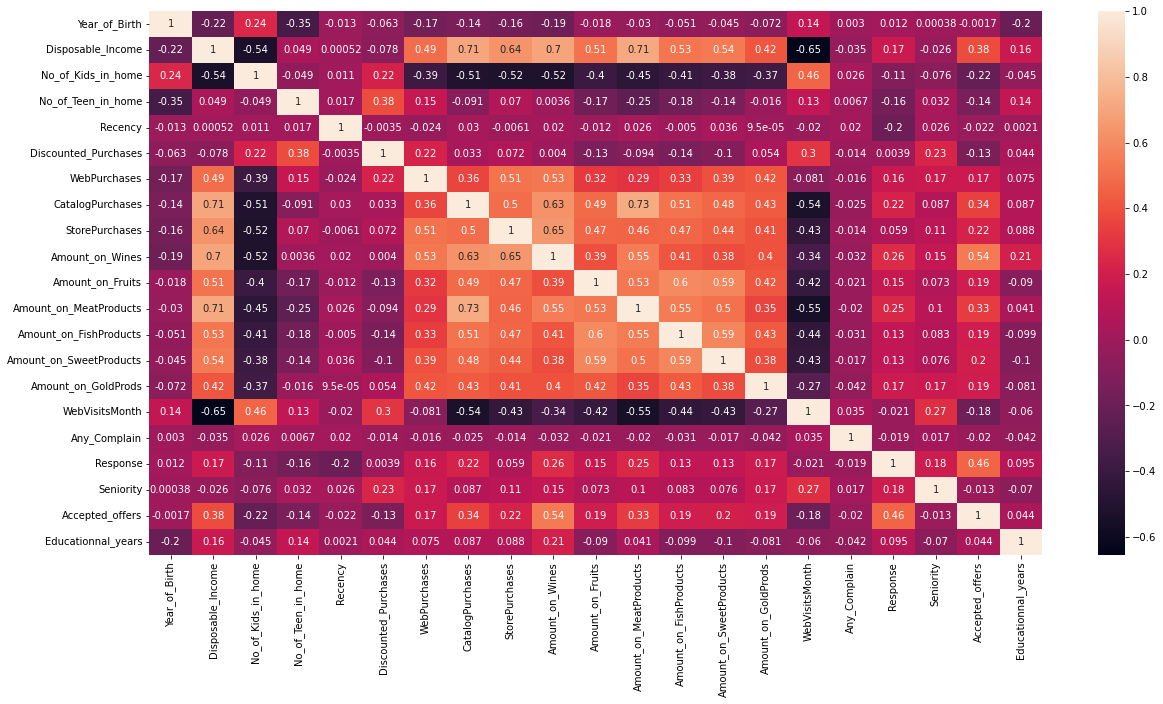

In [10]:
# Correlation
plt.figure(figsize=(20,10))
c= dataset.corr()
sns.heatmap(c,annot=True);

In [11]:
dataset=dataset.drop(columns=['Disposable_Income','WebVisitsMonth','Any_Complain','Year_of_Birth'])
#Final dataset before modeling
dataset

,ID,Marital_Status,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,Response,Seniority,Accepted_offers,Educationnal_years,Segment
0,ID_4A9AR6FQ,Divorced,1,1,56,2,1,1,4,71,3,16,0,6,20,0,79.466667,0,12,About to sleep
1,ID_X28T3VEK,Together,0,1,17,6,5,1,8,205,22,111,50,15,19,0,90.300000,0,12,Potential loyalist
2,ID_AWXARH57,Single,0,0,17,0,7,4,7,469,31,873,29,18,37,1,86.566667,1,12,Potential loyalist
3,ID_FQVZHE81,Single,1,0,49,3,4,1,3,56,15,49,17,24,24,0,88.866667,0,8,Potential loyalist
4,ID_QVLWGPRN,Married,0,0,59,1,3,7,9,412,117,445,181,165,203,0,84.533333,1,12,Loyal customers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,ID_XWINUFGG,Married,1,1,24,2,2,0,3,29,4,10,2,0,4,0,79.566667,0,12,New customers
1558,ID_GLVIHZLR,Single,0,1,63,1,4,2,8,167,53,100,55,30,27,0,90.100000,0,12,Need attention
1559,ID_O11VSIJY,Married,0,1,74,4,2,2,9,820,11,53,11,0,70,0,96.900000,1,18,Need attention
1560,ID_VS37P6MS,Single,1,1,28,2,1,0,4,57,3,9,0,0,1,0,81.833333,0,21,New customers


In [12]:
X=dataset.drop(columns=['Response', 'ID'])
Y=dataset['Response']
#1. Split data into X and Y. We use stratify to keep an equal proportion of examples in each class between train set and test set
X_train, X_test, y_train, y_test = train_test_split(X,Y ,test_size=0.2, random_state=42,shuffle=True, stratify=Y)

In [13]:
numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # Select only the numeric features
                         ('unskewed', df_unskewed()), #Unskew data
                         ('scl', df_scaler()) # Scale data
                        ])  
categorical_pipeline = Pipeline( steps = [( 'fs', feat_sel(dtype='category')), # Select only the categorical features
                                          ('label_encoder', Label_encode()), #Label encoder
                                          ])
processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', categorical_pipeline),
                                                    ('num_pipe', numeric_pipe)
                                                   ])

In [14]:
%%time

#Outer loop
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
outer_results = list()

for train_ix, valid_ix in cv_outer.split(X_train,y_train):
    Xtrain, X_valid = X_train.iloc[train_ix, :], X_train.iloc[valid_ix, :]
    ytrain, y_valid = y_train.iloc[train_ix], y_train.iloc[valid_ix]
       
    #our pipeline    
    pipe = Pipeline([
    ('prep',processing_pipe),
    ('selector', SelectKBest(f_classif, k=10)),
    ('resample' ,SMOTETomek(sampling_strategy=0.7,random_state=1)),
    ('est', Model_selection())])
    
    #search space containing feature selection, preprocessing steps and model hyperparameters
    search_space = [
                {'est__estimator':[SVC()],
                 'selector__k': [10,14,18],
                 'est__estimator__C': [0.1,1,10],
                 'est__estimator__kernel': ['rbf', 'poly'],
                 'est__estimator__random_state' : [1],
                 'est__estimator__verbose' : [False],
                 'prep__num_pipe__unskewed__method': ['yeo-johnson','None'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]},
        
                {'est__estimator':[LogisticRegression()],
                'selector__k': [10,14,18],
                'est__estimator__random_state' : [1],
                 'est__estimator__verbose' : [False],
                 'prep__num_pipe__unskewed__method': ['yeo-johnson','None'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]},    
        
                {'est__estimator':[KNeighborsClassifier()],
                 'selector__k': [10,14,18],
                 'est__estimator__n_neighbors': [3,5,11,15],
                 'est__estimator__metric' : ['euclidean', 'manhattan'],
                 'prep__num_pipe__unskewed__method': ['yeo-johnson','None'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]},
        
                {'est__estimator':[LinearDiscriminantAnalysis()],
                 'selector__k': [10,14,18],
                 'est__estimator__solver':  ['svd', 'lsqr'],
                 'prep__num_pipe__unskewed__method': ['yeo-johnson','None'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]},
        
                {'est__estimator':[RandomForestClassifier()],
                 'selector__k': [10,14,18],
                 'est__estimator__random_state' : [1],
                 'est__estimator__n_estimators': [10, 100, 1000],
                 'est__estimator__max_features' : ['sqrt', 'log2'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]}, 

                {'est__estimator': [CatBoostClassifier()],
                 'selector__k': [10,14,18],
                 'est__estimator__random_state' : [1],
                 'est__estimator__silent' : [True],
                 'est__estimator__early_stopping_rounds':[100],
                 'est__estimator__loss_function':['CrossEntropy'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]},
                  ]
    #inner loop
    cv_inner=StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    clf = GridSearchCV(pipe, search_space,cv=cv_inner, scoring='f1_weighted',refit=True)
    clf.fit(Xtrain, ytrain)

    best_model = clf.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_valid)
    # F1 score
    F1 = f1_score(y_valid, yhat,average='weighted')
    # store the result
    outer_results.append(F1)
    # report best model for each fold of the outer loop
    print('>F1=%.3f, best score=%.3f, model=%s' % (F1, clf.best_score_, clf.best_params_))
# Get a summarized result
print('Weighted F1-score: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>F1=0.880, best score=0.874, model={'est__estimator': <catboost.core.CatBoostClassifier object at 0x000002530097BDF0>, 'est__estimator__early_stopping_rounds': 100, 'est__estimator__loss_function': 'CrossEntropy', 'est__estimator__random_state': 1, 'est__estimator__silent': True, 'prep__num_pipe__scl__method': StandardScaler(), 'selector__k': 18}
>F1=0.887, best score=0.868, model={'est__estimator': LogisticRegression(random_state=1, verbose=False), 'est__estimator__random_state': 1, 'est__estimator__verbose': False, 'prep__num_pipe__scl__method': StandardScaler(), 'prep__num_pipe__unskewed__method': 'None', 'selector__k': 18}
>F1=0.887, best score=0.887, model={'est__estimator': <catboost.core.CatBoostClassifier object at 0x000002530097BFA0>, 'est__estimator__early_stopping_rounds': 100, 'est__estimator__loss_function': 'CrossEntropy', 'est__estimator__random_state': 1, 'est__estimator__silent': True, 'prep__num_pipe__scl__method': RobustScaler(), 'selector__k': 18}
>F1=0.875, best sc

In [15]:
def format_cv_results(search):
    df = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
    df = df.sort_values("Score", ascending=False)
    return df.fillna(value="")
df_res = format_cv_results(clf)
df_res.head(10)

,est__estimator,est__estimator__C,est__estimator__kernel,est__estimator__random_state,est__estimator__verbose,prep__num_pipe__scl__method,prep__num_pipe__unskewed__method,selector__k,est__estimator__metric,est__estimator__n_neighbors,est__estimator__solver,est__estimator__max_features,est__estimator__n_estimators,est__estimator__early_stopping_rounds,est__estimator__loss_function,est__estimator__silent,Score
236,"RandomForestClassifier(max_features='sqrt', n_...",,,1,,StandardScaler(),,18,,,,log2,1000,,,,0.884877
218,"RandomForestClassifier(max_features='sqrt', n_...",,,1,,StandardScaler(),,18,,,,sqrt,1000,,,,0.884877
212,"RandomForestClassifier(max_features='sqrt', n_...",,,1,,StandardScaler(),,18,,,,sqrt,100,,,,0.884572
230,"RandomForestClassifier(max_features='sqrt', n_...",,,1,,StandardScaler(),,18,,,,log2,100,,,,0.884572
29,SVC(),1,rbf,1,False,StandardScaler(),None,18,,,,,,,,,0.882986
242,<catboost.core.CatBoostClassifier object at 0x...,,,1,,StandardScaler(),,18,,,,,,100,CrossEntropy,True,0.882796
245,<catboost.core.CatBoostClassifier object at 0x...,,,1,,RobustScaler(),,18,,,,,,100,CrossEntropy,True,0.880937
241,<catboost.core.CatBoostClassifier object at 0x...,,,1,,StandardScaler(),,14,,,,,,100,CrossEntropy,True,0.880891
217,"RandomForestClassifier(max_features='sqrt', n_...",,,1,,StandardScaler(),,14,,,,sqrt,1000,,,,0.880677
235,"RandomForestClassifier(max_features='sqrt', n_...",,,1,,StandardScaler(),,14,,,,log2,1000,,,,0.880677


In [16]:
def objective_catboost(trial):
    numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # Select only the numeric features
                             ('scl', df_scaler(method=RobustScaler())) # Scale data
                             ]) 
                         
    categorical_pipeline = Pipeline( steps = [( 'fs', feat_sel(dtype='category')), # Select only the categorical features
                                              ('label_encoder', Label_encode()), #Label encoder
                                             ])
    processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', categorical_pipeline),
                                                        ('num_pipe', numeric_pipe)])        
    
    cv_outer=StratifiedKFold(n_splits=5, random_state=1,shuffle=True)  
    param = {        
        'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1),
        'n_estimators': trial.suggest_int( "n_estimators",  50,300,20),
        'max_depth': trial.suggest_int( 'max_depth',  1,5,1),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg',1,5,1),
        'random_state': trial.suggest_categorical('random_state',[1]),
        'loss_function': trial.suggest_categorical('loss_function',['CrossEntropy']),
        'eval_metric': trial.suggest_categorical('eval_metric',['F1']),
        'silent':trial.suggest_categorical('silent',[True]), 
        'early_stopping_rounds':trial.suggest_categorical('early_stopping_rounds',[100])}   
    pipe = Pipeline([
        ('prep',processing_pipe),
        ('resample' ,SMOTETomek(sampling_strategy=0.7,random_state=1)),
        ('est', CatBoostClassifier(**param))])     
    return cross_val_score(pipe, X_train, y_train,cv=cv_outer,scoring="f1_weighted").mean()

In [17]:
%%time
models=[]
scores=[]
catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(objective_catboost, n_trials=50)
model='Catboost'
score=catboost_study.best_trial.value
models.append(model)
scores.append(score)

[I 2021-10-19 03:50:17,819] A new study created in memory with name: no-name-72edd906-14c2-4949-9d46-8f0b4385f602
[I 2021-10-19 03:50:21,789] Trial 0 finished with value: 0.8826960804987409 and parameters: {'learning_rate': 0.0667178056487525, 'n_estimators': 150, 'max_depth': 4, 'l2_leaf_reg': 1, 'random_state': 1, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1', 'silent': True, 'early_stopping_rounds': 100}. Best is trial 0 with value: 0.8826960804987409.
[I 2021-10-19 03:50:24,722] Trial 1 finished with value: 0.8845168038472989 and parameters: {'learning_rate': 0.06448604697253989, 'n_estimators': 90, 'max_depth': 4, 'l2_leaf_reg': 4, 'random_state': 1, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1', 'silent': True, 'early_stopping_rounds': 100}. Best is trial 1 with value: 0.8845168038472989.
[I 2021-10-19 03:50:29,462] Trial 2 finished with value: 0.8834141954194408 and parameters: {'learning_rate': 0.07112289220821637, 'n_estimators': 230, 'max_depth': 2, 'l2_leaf_reg

Wall time: 5min 40s


In [18]:
print('Number of finished trials:', len(catboost_study.trials))
print('Best trial: score {}, params {}'.format(catboost_study.best_trial.value, catboost_study.best_trial.params))

Number of finished trials: 50
Best trial: score 0.8898188891148479, params {'learning_rate': 0.02607804795639472, 'n_estimators': 230, 'max_depth': 5, 'l2_leaf_reg': 1, 'random_state': 1, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1', 'silent': True, 'early_stopping_rounds': 100}


In [19]:
def objective_random_forest(trial):
    numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # Select only the numeric features
                         ('scl', df_scaler(method=RobustScaler())) # Scale data
                        ])  
    categorical_pipeline = Pipeline( steps = [( 'fs', feat_sel(dtype='category')), # Select only the categorical features
                                          ('label_encoder', Label_encode()), #Label encoder
                                          ])
    processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', categorical_pipeline),
                                                    ('num_pipe', numeric_pipe)
                                                   ])
    
    cv_outer=StratifiedKFold(n_splits=5, random_state=1,shuffle=True)
    param = {        
        'n_estimators': trial.suggest_int( 'n_estimators',  10,1000,200),
        'max_features': trial.suggest_categorical( 'max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_categorical('max_depth',[10, 20, 30,None]),
        'bootstrap': trial.suggest_categorical('bootstrap',[True, False]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,9,2),
        'random_state': trial.suggest_categorical('random_state',[1]),
        'criterion':trial.suggest_categorical('criterion',['gini', 'entropy']),
        'verbose':trial.suggest_categorical('verbose',[0]), 
        }
        
    pipe = Pipeline([
        ('prep',processing_pipe),
        ('resample' ,SMOTETomek(sampling_strategy=0.7,random_state=1)),
        ('est', RandomForestClassifier(**param))])     
    return cross_val_score(pipe, X_train, y_train,  cv=cv_outer,scoring="f1_weighted").mean()

In [20]:
%%time
RF_study = optuna.create_study(direction='maximize')
RF_study.optimize(objective_random_forest, n_trials=50)
model='Random Forest'
score=RF_study.best_trial.value
models.append(model)
scores.append(score)

[I 2021-10-19 03:55:58,573] A new study created in memory with name: no-name-321a5a91-30e0-4e17-8382-d54658fc1d0e
[I 2021-10-19 03:56:05,789] Trial 0 finished with value: 0.8795100526276466 and parameters: {'n_estimators': 210, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True, 'min_samples_leaf': 1, 'random_state': 1, 'criterion': 'gini', 'verbose': 0}. Best is trial 0 with value: 0.8795100526276466.
[I 2021-10-19 03:56:33,583] Trial 1 finished with value: 0.8803157275878079 and parameters: {'n_estimators': 810, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True, 'min_samples_leaf': 9, 'random_state': 1, 'criterion': 'entropy', 'verbose': 0}. Best is trial 1 with value: 0.8803157275878079.
[I 2021-10-19 03:57:10,336] Trial 2 finished with value: 0.8778058030780065 and parameters: {'n_estimators': 810, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False, 'min_samples_leaf': 3, 'random_state': 1, 'criterion': 'entropy', 'verbose': 0}. Best is trial 1 with valu

Wall time: 13min 5s


In [21]:
print('Number of finished trials:', len(RF_study.trials))
print('Best trial: score {}, params {}'.format(RF_study.best_trial.value, RF_study.best_trial.params))

Number of finished trials: 50
Best trial: score 0.8851044967240703, params {'n_estimators': 410, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False, 'min_samples_leaf': 7, 'random_state': 1, 'criterion': 'gini', 'verbose': 0}


In [22]:
def objective_SVC(trial):
    numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # Select only the numeric features
                         ('scl', df_scaler(method=RobustScaler())) # Scale data
                        ])  
    categorical_pipeline = Pipeline( steps = [( 'fs', feat_sel(dtype='category')), # Select only the categorical features
                                          ('label_encoder', Label_encode()), #Label encoder
                                          ])
    processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', categorical_pipeline),
                                                    ('num_pipe', numeric_pipe)
                                                   ])
    cv_outer=StratifiedKFold(n_splits=5, random_state=7,shuffle=True)
    param = {        
        'C': trial.suggest_loguniform('C', 1e-5, 1e2),
        'gamma': trial.suggest_loguniform('gamma',1e-4, 1e1), 
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly']),
        'random_state': trial.suggest_categorical('random_state',[1]),
        'verbose':trial.suggest_categorical('verbose',[0]), 
            }
        
    pipe = Pipeline([
        ('prep',processing_pipe),
        ('resample' ,SMOTETomek(sampling_strategy=0.7,random_state=1)),
        ('est', SVC(**param))])     
    return cross_val_score(pipe, X_train, y_train, cv=cv_outer, scoring="f1_weighted").mean()

In [23]:
%%time
SVC_study = optuna.create_study(direction='maximize')
SVC_study.optimize(objective_SVC, n_trials=50)
model='SVC'
score=SVC_study.best_trial.value
models.append(model)
scores.append(score)

[I 2021-10-19 04:09:04,648] A new study created in memory with name: no-name-5ff3ef8a-9e9c-4c47-a9b9-45b7232a0877
[I 2021-10-19 04:09:07,544] Trial 0 finished with value: 0.7765497957578799 and parameters: {'C': 0.2148615394484752, 'gamma': 4.115900451858483, 'kernel': 'rbf', 'random_state': 1, 'verbose': 0}. Best is trial 0 with value: 0.7765497957578799.
[I 2021-10-19 04:09:09,315] Trial 1 finished with value: 0.7769479514705692 and parameters: {'C': 0.10501197230736703, 'gamma': 0.0010056147254402935, 'kernel': 'rbf', 'random_state': 1, 'verbose': 0}. Best is trial 1 with value: 0.7769479514705692.
[I 2021-10-19 04:09:11,068] Trial 2 finished with value: 0.7769479514705692 and parameters: {'C': 0.0009008637536635176, 'gamma': 0.015804694136855185, 'kernel': 'rbf', 'random_state': 1, 'verbose': 0}. Best is trial 1 with value: 0.7769479514705692.
[I 2021-10-19 04:09:13,330] Trial 3 finished with value: 0.7769479514705692 and parameters: {'C': 0.001272060848654873, 'gamma': 0.003628295

Wall time: 1min 39s


In [24]:
print('Number of finished trials:', len(SVC_study.trials))
print('Best trial: score {}, params {}'.format(SVC_study.best_trial.value, SVC_study.best_trial.params))

Number of finished trials: 50
Best trial: score 0.8744715483078849, params {'C': 9.994815178167793, 'gamma': 0.0006180692076151264, 'kernel': 'rbf', 'random_state': 1, 'verbose': 0}


In [25]:
best_model = pd.DataFrame(list(zip(models, scores)), columns =['Model', 'Score']).sort_values(ascending=False,by='Score')
best_model

,Model,Score
0,Catboost,0.889819
1,Random Forest,0.885104
2,SVC,0.874472


In [26]:
best_params = catboost_study.best_params
best_params

{'learning_rate': 0.02607804795639472,
 'n_estimators': 230,
 'max_depth': 5,
 'l2_leaf_reg': 1,
 'random_state': 1,
 'loss_function': 'CrossEntropy',
 'eval_metric': 'F1',
 'silent': True,
 'early_stopping_rounds': 100}

In [27]:
numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # Select only the numeric features
                         ('scl', df_scaler(method=StandardScaler())) # Scale data
                        ])  
categorical_pipeline = Pipeline( steps = [( 'fs', feat_sel(dtype='category')), # Select only the categorical features
                                          ('label_encoder', Label_encode()), #Label encoder
                                          ])
processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', categorical_pipeline),
                                                    ('num_pipe', numeric_pipe)
                                                   ])

pipe = Pipeline([
        ('prep',processing_pipe),
        ('resample' ,SMOTETomek(sampling_strategy=0.7,random_state=1)),
        ('est', CatBoostClassifier(**best_params))])     

pipe.fit(X_train,y_train)
prediction = pipe.predict(X_test)

print('Weighted F1_score: %.0f%% ' % (f1_score(y_test, prediction, average='weighted')*100)) 
print(classification_report(y_test, prediction))

Weighted F1_score: 89% 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       265
           1       0.67      0.60      0.64        48

    accuracy                           0.89       313
   macro avg       0.80      0.78      0.79       313
weighted avg       0.89      0.89      0.89       313



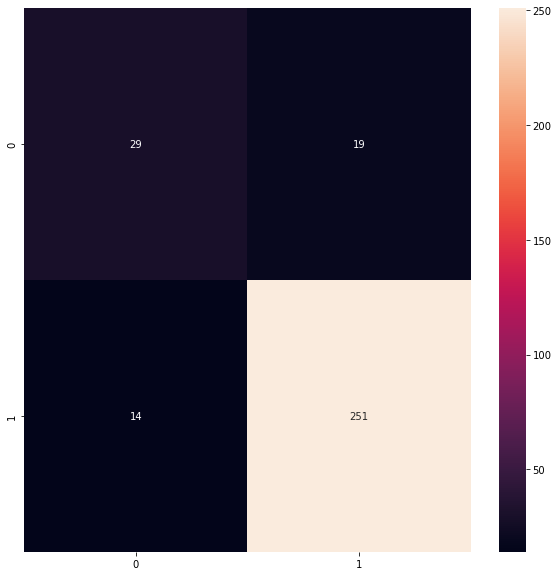

In [28]:
# confusion marix for the test data
cm = confusion_matrix(y_test, prediction,  labels=[1,0])

fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g', ax = ax);

In [29]:
df_test = pd.read_csv("Test.csv")

In [30]:
last_date = date(2020,12,31)
df_test['Seniority']=pd.to_datetime(df_test['Date_Customer'], dayfirst=True,format = '%d-%m-%Y')
df_test['Seniority'] = pd.to_numeric(df_test['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')/30
df_test['Accepted_offers']=df_test['Cmp1Accepted']+df_test['Cmp2Accepted']+df_test['Cmp3Accepted']+df_test['Cmp4Accepted']+df_test['Cmp5Accepted']
df_test['Educationnal_years']=df_test['Education_Level'].replace({'Basic':5,'2n Cycle':8,'Graduation':12,'Master':18,'PhD':21})
# df_test = df_test[df_test['WebPurchases']+df_test['CatalogPurchases']+df_test['StorePurchases'] > 0]
df_test=df_test.drop(columns=['Cmp1Accepted','Cmp2Accepted','Cmp3Accepted','Cmp4Accepted','Cmp5Accepted','Education_Level','Date_Customer'])
#1.Outliers removal
# df_test=df_test[df_test['Disposable_Income']<600000]
df_test = df_test.drop(df_test[df_test['Disposable_Income']> 600000].index).reset_index(drop=True)

#1.Dataframe creation
recency_df = df_test[['ID','Recency']]
frequency_df = df_test[['ID','WebPurchases','CatalogPurchases','StorePurchases']]
frequency_df['Transactions']=frequency_df['WebPurchases']+frequency_df['CatalogPurchases']+frequency_df['StorePurchases']
frequency_df=frequency_df.drop(columns=['WebPurchases','CatalogPurchases','StorePurchases'])

temp_df = recency_df.merge(frequency_df,on='ID')
monetary_df = df_test[['ID','Amount_on_Wines','Amount_on_Fruits','Amount_on_MeatProducts','Amount_on_FishProducts','Amount_on_SweetProducts','Amount_on_GoldProds']]
monetary_df['Spending']=monetary_df['Amount_on_Wines']+df_test['Amount_on_Fruits']+df_test['Amount_on_MeatProducts']+df_test['Amount_on_FishProducts']+df_test['Amount_on_SweetProducts']+df_test['Amount_on_GoldProds']
monetary_df=monetary_df.drop(columns=['Amount_on_Wines','Amount_on_Fruits','Amount_on_MeatProducts','Amount_on_FishProducts','Amount_on_SweetProducts','Amount_on_GoldProds'])
RFM=recency_df.merge(frequency_df,on='ID').merge(monetary_df,on='ID')
RFM.columns = ['ID','Recency','Frequency','Monetary']

#2.Clusters creation
kmedoids_recency = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(RFM[['Recency']])
RFM['RecencyCluster'] = kmedoids_recency.predict(RFM[['Recency']])
kmedoids_frequency = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(RFM[['Frequency']])
RFM['FrequencyCluster'] = kmedoids_frequency.predict(RFM[['Frequency']])
kmedoids_monetary = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(RFM[['Monetary']])
RFM['MonetaryCluster'] = kmedoids_monetary.predict(RFM[['Monetary']])

3.#Clusters ordering
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

RFM = order_cluster('RecencyCluster', 'Recency',RFM,False)
RFM = order_cluster('FrequencyCluster', 'Frequency',RFM,True)
RFM = order_cluster('MonetaryCluster', 'Monetary',RFM,True)


#4.Segments creation
segt_map = {
    r'30': 'Promising',
    r'23': 'Loyal customers',
    r'24': 'Loyal customers',
    r'33': 'Loyal customers',
    r'34': 'Loyal customers',
    r'43': 'Loyal customers',
    r'32': 'Potential loyalist',
    r'31': 'Potential loyalist',
    r'42': 'Potential loyalist',
    r'41': 'Potential loyalist',
    r'21': 'Need attention',
    r'22': 'Need attention',
    r'12': 'Need attention',
    r'11': 'Need attention',
    r'40': 'New customers',
    r'20': 'About to sleep',
    r'14': 'Cant loose them',
    r'04': 'Cant loose them',
    r'10': 'Lost',
    r'00': 'Lost',
    r'01': 'Lost',
    r'02': 'At risk',
    r'03': 'At risk',
    r'13': 'At risk',
    r'44': 'Champions',
}
#We create the segment and merge with our main df_test
RFM['Segment'] = RFM['RecencyCluster'].map(str) + RFM['FrequencyCluster'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
df_test=df_test.merge(RFM[['ID','Segment']],on='ID')
df_test

,ID,Year_of_Birth,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,...,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Any_Complain,Seniority,Accepted_offers,Educationnal_years,Segment
0,ID_ZPMABNVX,1954,Single,48556.8,0,1,85,6,8,2,...,118,7,23,41,8,0,97.033333,0,12,At risk
1,ID_WFE91NAA,1961,Widow,57499.2,0,1,79,5,7,4,...,26,0,0,75,6,0,98.700000,1,12,At risk
2,ID_JV11RBRK,1973,Married,17025.6,0,0,47,1,2,0,...,11,16,12,27,6,0,95.433333,0,5,Potential loyalist
3,ID_6B7SVKY9,1970,Together,91983.6,0,0,98,1,4,7,...,946,219,189,126,2,0,89.800000,2,12,Cant loose them
4,ID_GOVUZ545,1959,Together,78235.2,0,2,41,2,7,6,...,181,12,0,200,5,0,90.533333,1,12,Loyal customers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,ID_1D68PV28,1975,Married,80934.0,0,1,70,5,9,6,...,217,29,80,11,6,0,102.100000,0,12,Cant loose them
668,ID_TM6CYFZO,1955,Divorced,84052.8,0,1,53,4,7,10,...,250,153,14,14,5,0,95.766667,0,12,Loyal customers
669,ID_VHR666SC,1952,Married,63974.4,0,0,39,1,5,1,...,12,0,0,25,7,0,90.033333,0,21,Potential loyalist
670,ID_O852YAO1,1960,Together,69548.4,0,1,31,7,4,6,...,177,77,5,29,3,1,89.700000,0,12,Loyal customers


In [31]:
df_test.drop(columns=['ID', 'Year_of_Birth', 'Disposable_Income','Any_Complain', 'WebVisitsMonth'], inplace=True)
df_test.head(2)

,Marital_Status,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,Seniority,Accepted_offers,Educationnal_years,Segment
0,Single,0,1,85,6,8,2,8,429,20,118,7,23,41,97.033333,0,12,At risk
1,Widow,0,1,79,5,7,4,6,510,3,26,0,0,75,98.700000,1,12,At risk


In [32]:
X.head(2)

,Marital_Status,No_of_Kids_in_home,No_of_Teen_in_home,Recency,Discounted_Purchases,WebPurchases,CatalogPurchases,StorePurchases,Amount_on_Wines,Amount_on_Fruits,Amount_on_MeatProducts,Amount_on_FishProducts,Amount_on_SweetProducts,Amount_on_GoldProds,Seniority,Accepted_offers,Educationnal_years,Segment
0,Divorced,1,1,56,2,1,1,4,71,3,16,0,6,20,79.466667,0,12,About to sleep
1,Together,0,1,17,6,5,1,8,205,22,111,50,15,19,90.300000,0,12,Potential loyalist


In [33]:
sub_prediction = pipe.predict(df_test)
sub_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
Id = pd.read_csv("Test.csv")
id_col = Id['ID']
submission = pd.DataFrame({'ID':id_col, 'Response':sub_prediction})
submission

,ID,Response
0,ID_ZPMABNVX,0
1,ID_WFE91NAA,0
2,ID_JV11RBRK,0
3,ID_6B7SVKY9,0
4,ID_GOVUZ545,0
...,...,...
667,ID_1D68PV28,0
668,ID_TM6CYFZO,0
669,ID_VHR666SC,0
670,ID_O852YAO1,0


In [35]:
submission.to_csv('cat_sub.csv', index=False)

In [36]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install -U notebook-as-pdf

  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61101 sha256=abe3706ca20fee580547bd9f2bb720a21cadf91970084757febdd157c3e67e4a
  Stored in directory: c:\users\adebi\appdata\local\pip\cache\wheels\b1\1a\8f\a4c34be976825a2f7948d0fa40907598d69834f8ab5889de11
Successfully built PyPDF2
Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install nbconvert[webpdf]

  Attempting uninstall: websockets
    Found existing installation: websockets 9.1
    Uninstalling websockets-9.1:
      Successfully uninstalled websockets-9.1
  Attempting uninstall: pyee
    Found existing installation: pyee 8.2.2
    Uninstalling pyee-8.2.2:
      Successfully uninstalled pyee-8.2.2
  Attempting uninstall: pyppeteer
    Found existing installation: pyppeteer 0.2.6
    Uninstalling pyppeteer-0.2.6:
      Successfully uninstalled pyppeteer-0.2.6
Note: you may need to restart the kernel to use updated packages.


In [40]:
pip install pyppeteer

Note: you may need to restart the kernel to use updated packages.


In [41]:
jupyter-nbconvert --to PDFviaHTML AbdulBaaqi_DSN_BootCamp_Qualification_2021.ipynb

SyntaxError: invalid syntax (Temp/ipykernel_25980/2731551844.py, line 1)

In [42]:
--allow-chromium-download

NameError: name 'allow' is not defined

In [43]:
pip install nbconvert --allow-chromium-download

Note: you may need to restart the kernel to use updated packages.



Usage:   
  D:\anaconda3\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  D:\anaconda3\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  D:\anaconda3\python.exe -m pip install [options] [-e] <vcs project url> ...
  D:\anaconda3\python.exe -m pip install [options] [-e] <local project path> ...
  D:\anaconda3\python.exe -m pip install [options] <archive url/path> ...

no such option: --allow-chromium-download


In [44]:
jupyter nbconvert --to webpdf --allow-chromium-download AbdulBaaqi_DSN_BootCamp_Qualification_2021.ipynb

SyntaxError: invalid syntax (Temp/ipykernel_25980/1661704931.py, line 1)

In [2]:
import nbconvert

In [46]:
jupyter-nbconvert --to PDFviaHTML AbdulBaaqi_DSN_BootCamp_Qualification_2021.ipynb

SyntaxError: invalid syntax (Temp/ipykernel_25980/2731551844.py, line 1)

In [48]:
jupyter-nbconvert --to webpdf --allow-chromium-download AbdulBaaqi_DSN_BootCamp_Qualification_2021.ipynb

SyntaxError: invalid syntax (Temp/ipykernel_25980/1831231327.py, line 1)

In [3]:
nbconvert --allow-chromium-download

NameError: name 'allow' is not defined

In [4]:
miktexsetup_standalone --verbose --local-package-repository=C:\temp\miktex --package-set=complete download

SyntaxError: invalid syntax (Temp/ipykernel_11124/2965702052.py, line 1)